# Web Scraper
  
  
The task is to write a web scraper in Python 3 which scrapes data from job descriptions. You can find the links to the job descriptions in the ‘Link’ column of the file downloadable at this link:  
  
https://assets.digitalmarketplace.service.gov.uk/digital-outcomes-and-specialists-5/communications/data/opportunity-data.csv 
  
Please note:  
* The web scraper scrapes data from 2 fields within each job description: ‘Expected contract length’ and ‘Budget Range’
* The program outputs a json file with the number of each job description (which can be found at the end of each job description url) as a key, and a dictionary as a value 
* The dictionary should contain ‘Expected contract length’ and ‘Budget Range’ as keys, and the scraped data for each field as values.  
* The program also outputs the average contract length and the average budget range. 

## 0. Set up our environment
We need to import some packages for ease of processing this data.

Some of these may need to be installed using `pip install <name of package>`

I am using a new anaconda environment for python 3.8.12 and have installed the below packages along with their prerequisites.
* ipykernel
* pandas
* requests
* beautifulsoup4

In [528]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import datetime
import seaborn as sns
import re

## 1. Download and save the input data
Using the pandas `read_csv` function we can download the csv file and load it directly into a pandas dataframe.

Before using this method I was trying to use the `requests` package to get the CSV as a stream and save this to the file line by line. This took over three minutes to complete for a relatively small file. I was very glad to find this much quicker and simpler alternative.


In [76]:
CSV_URL = 'https://assets.digitalmarketplace.service.gov.uk/digital-outcomes-and-specialists-5/communications/data/opportunity-data.csv '
data = pd.read_csv(CSV_URL)

We use the head function to take a quick look at the date and check that it looks sensible, and the len function to see how many rows we are dealing with


In [78]:
print(f"Our table is {len(data)} rows long and the first few rows look like this:")
data.head()

Our table is 4727 rows long and the first few rows look like this:


,ID,Opportunity,Link,Framework,Category,Specialist,Organisation Name,Buyer Domain,Location Of The Work,Published At,...,Applications from SMEs,Applications from Large Organisations,Total Organisations,Status,Winning supplier,Size of supplier,Contract amount,Contract start date,Clarification questions,Employment status
0,5,Alpha to replace www.enterprise-europe.co.uk,https://www.digitalmarketplace.service.gov.uk/...,digital-outcomes-and-specialists,digital-outcomes,NaN,Innovate UK,innovateuk.gov.uk,Offsite,2016-04-28,...,28,9,37,closed,NaN,NaN,NaN,NaN,45,NaN
1,9,HSCIC Dev Ops Contract - SOW 1 - Spine,https://www.digitalmarketplace.service.gov.uk/...,digital-outcomes-and-specialists,digital-outcomes,NaN,Health & Social Care Information Centre (HSCIC...,hscic.gov.uk,Yorkshire and the Humber,2016-07-13,...,6,6,12,closed,NaN,NaN,NaN,NaN,16,NaN
2,19,Programme CORTISONE - Scrum Master,https://www.digitalmarketplace.service.gov.uk/...,digital-outcomes-and-specialists,digital-specialists,deliveryManager,Ministry of Defence,mod.uk,South West England,2016-05-03,...,25,9,34,closed,NaN,NaN,NaN,NaN,13,NaN
3,20,Electronic Range Action Safety Plan (ERASP),https://www.digitalmarketplace.service.gov.uk/...,digital-outcomes-and-specialists,digital-outcomes,NaN,Ministry Of Defence (MOD),mod.uk,South West England,2016-05-05,...,4,4,8,closed,NaN,NaN,NaN,NaN,7,NaN
4,28,Programme CORTISONE - Application Architect (S...,https://www.digitalmarketplace.service.gov.uk/...,digital-outcomes-and-specialists,digital-specialists,technicalArchitect,Ministry of Defence,mod.uk,South West England,2016-05-03,...,14,7,21,closed,NaN,NaN,NaN,NaN,13,NaN


We save this to a file called `input_data.csv` to prevent having to query the website too many times.
We use the `index=False` flag to prevent adding an index column to the CSV file.

In [84]:
with open("input_data.csv", 'wb') as input_data_file:
    data.to_csv(input_data_file, index=False)

## 2. Using the input data to extract required fields

We start by reading back in the data that we collected from the previous steps using the pandas `read_csv` function.

Because we are using jupyter notebooks, this means we can only run the query to download the original file once and then read that data back as many times as we like.

In [85]:
input_data = pd.read_csv("input_data.csv")


We then discard all columns except the `Link` column

In [96]:
url_list = input_data["Link"]

Something that I wish I had done before starting writing the next code block was to look more closely at the CSV data, one of the columns contains the `Expected Contract Length` column already, so there was no need to scrape this from the webpage later.

In [97]:
print(input_data.columns)

Index(['ID', 'Opportunity', 'Link', 'Framework', 'Category', 'Specialist',
       'Organisation Name', 'Buyer Domain', 'Location Of The Work',
       'Published At', 'Open For', 'Expected Contract Length',
       'Applications from SMEs', 'Applications from Large Organisations',
       'Total Organisations', 'Status', 'Winning supplier', 'Size of supplier',
       'Contract amount', 'Contract start date', 'Clarification questions',
       'Employment status'],
      dtype='object')


Next we want to gather the requested information (Expected contract length and Budget range).

As this has been requested to be saved in a JSON format the first thing to do is to create an empty dictionary.

In [63]:
output_data = {}

Next we want to start populating the dictionary that we just created by iterating over each URL in our list.

The required information for each entry is an ID (required), an expected contract length, and a budget range.

The ID is simple as is is the section of the URL after the last `/` which can be found by using `url.split("/")` to split the URL into a list of strings that were delimited by `/` and then using `[-1]` to get the last one of these pieces.

I used empty strings to initialise the contract length and budget range variables at the start of each loop. This prevents data from a previous iteration being saved to the next row. However, I believe I should have used a NA or NAN value instead.
```python
    contract_length = ''
    budget_range = ''  
```

Now we get the website text using `requests.get(url).text` and pass this directly into a BeautifulSoup object using an `html.parser` setting to make processing the data simpler.

Reviewing the HTML alongside a webpage using a browser developer mode allowed me to identify which section of the webpage I needed to locate.
* First find the `h2` tag with a class=`opportunity-attributes-1`
* Look for the next `dl` tag
* Within this `dl` tag review each `div` tag with a class=`govuk-summary-list__row`
* The row title will be found in the `dt` tag and I used the `strip` method to remove whitespace at the start and end of the text
* We then check to see if the row title is either `Expected contract length` or `Budget range`, and if so, store the text from the `dd` field of the same row into an appropriate variable

After extracting the required fields we then store the data that we have found for this row into our `output_data` dictionary

After I initially ran this code and it was very slow, I added a print statement to the end of the loop so that I could review the progress of the loop and ensure that it was not stuck somewhere.

Unfortunately it just appears that this method works but is slow, this section of code took my device approximately *30 minutes* to run.

I intend to review the output of the printed logs to see if each loop took longer as time went on or if each loop is slow to run.

If it is a slow loop then perhaps I can look to refactor the code to make it more efficient.

Having not scraped such a large number of websites before I am not sure if this level of performance is to be expected but honestly I was just glad to have some working code!

In [69]:
for url in url_list:
    ID = url.split("/")[-1]
    contract_length = ''
    budget_range = ''   
    website_html = BeautifulSoup(requests.get(url).text, "html.parser")
    overview_header = website_html.find('h2', id="opportunity-attributes-1")
    overview_table = overview_header.findNext('dl')
    for row in overview_table.findAll("div", class_="govuk-summary-list__row"):
        row_header = row.find('dt').text.strip()
        if row_header == "Expected contract length":
            contract_length = row.find('dd').text.strip()
        if row_header == "Budget range":
            budget_range = row.find('dd').text.strip()
    output_data[ID] = {"Expected contract length": contract_length, "Budget range": budget_range}
    print(f"{datetime.datetime.now().time()}: ID {ID}: {output_data[ID]}")

08:35:27.779784: ID 5: {'Expected contract length': '8 weeks', 'Budget range': 'c£100k for people + £7k for tech'}
08:35:28.198296: ID 9: {'Expected contract length': '2 Years', 'Budget range': 'The Call-Off contract will have a maximum value of up to £28m per annum.This cap is the cumulative total of spend approval across all suppliers during the term of the Call-Off Contract. Therefore, this is the cumulative aggregate spend across all such suppliers and is not indicative of the spend under this proposed Call-Off Contract.Each Statement of Work shall detail the allocated spend to that particular project.Pricing submission documents are available on the Delta portal and pricing requirements are outlined in the Instruction Document which are posted Delta.  The web link is https://www.delta-esourcing.com/ and access Code: N7BGV62ZP6'}
08:35:28.600661: ID 19: {'Expected contract length': '9 months', 'Budget range': ''}
08:35:28.985584: ID 20: {'Expected contract length': 'Completion by J

Once the above loop had finally finished it was time to save the data to JSON, thankfully this was very quick and simple.

I added the `indent=4` flag to make the JSON slightly more human readable.

In [95]:
with open('extracted_data.json', 'w') as extracted_file:
    json.dump(output_data, extracted_file, indent=4)

## 3. Getting ready to start calculating averages

Lets get our data into a nice dataframe to start with

In [230]:
extracted_data = pd.read_json("extracted_data.json")
extracted_data.head()

,5,9,19,20,28,29,30,31,32,48,...,16470,16472,16473,16488,16493,16515,16520,16521,16522,16563
Expected contract length,8 weeks,2 Years,9 months,Completion by January 2017,9 Months,9 Months,9 Months,9 months,2 Years,3 months + 3 month extension (if required),...,2 months +4 months(optional),12 months,,14 Months,21 months with an option to extend by up to 25...,"12 months, with possible 12 month extension",Five months. Discovery and Alpha phases to be...,12 months,6 months with a potential to extend for up to ...,
Budget range,c£100k for people + £7k for tech,The Call-Off contract will have a maximum valu...,,,,,,,,,...,"£40,000- £60,00",,,£3.5million,,"The anticipated budget range between £400,000 ...","Up to £100,000 inclusive of VAT for the Discov...",,,


No not like that - lets try transposing the data

In [231]:
extracted_data = extracted_data.T
extracted_data.head()

,Expected contract length,Budget range
5,8 weeks,c£100k for people + £7k for tech
9,2 Years,The Call-Off contract will have a maximum valu...
19,9 months,
20,Completion by January 2017,
28,9 Months,


Better but those headers are going to be annoying to work with, lets rename them.

In [232]:
extracted_data.rename(columns={
    "Expected contract length": "length", 
    "Budget range": "budget"}, 
    inplace=True)
extracted_data.head()

,length,budget
5,8 weeks,c£100k for people + £7k for tech
9,2 Years,The Call-Off contract will have a maximum valu...
19,9 months,
20,Completion by January 2017,
28,9 Months,


And now lets convert everything to lowercase.

In [233]:
extracted_data["length"] = extracted_data["length"].str.lower()
extracted_data["budget"] = extracted_data["budget"].str.lower()
extracted_data.head()

,length,budget
5,8 weeks,c£100k for people + £7k for tech
9,2 years,the call-off contract will have a maximum valu...
19,9 months,
20,completion by january 2017,
28,9 months,


## 4. Cleaning length data

Initially I thought this might be simple but reviewing the extracted data gave me second thoughts.
Some sample data for contract length includes:
* Completion by January 2017
* 25 days
* We expect this engagement to run for 9months
* An initial 6 month discovery phase followed by up to a further 18 months at DWP's sole discretion
* 2-4 months


Now how many job postings have an expected contract length at all?

In [234]:
has_length = len(extracted_data[extracted_data["length"] != ""])
no_length = len(extracted_data[extracted_data["length"] == ""])
total_records = (has_length + no_length)

percent_with_length_data = 100 * (has_length / total_records)

print(f"Of {total_records} records, {has_length} records ({percent_with_length_data:.1f}%) have contract length data and {no_length} do not have contract length data")

Of 4724 records, 4324 records (91.5%) have contract length data and 400 do not have contract length data


If we replace most punctuation this will help identify key words.

In [237]:
punctuation_to_remove = (
    "(",
    ")",
    ",",
    ".",
    "-",
    "?"
)

In [252]:
for symbol in punctuation_to_remove:
    extracted_data["length"] = extracted_data["length"].str.replace(symbol, " ")

C:\Users\rarms\AppData\Local\Temp\ipykernel_7976\1698923879.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  extracted_data["length"] = extracted_data["length"].str.replace(symbol, " ")


Let us first presume that the first time in the string that we find a word which could be converted into a number (such as 1, 23, 1968) followed by a time word (such as 'months', 'years' or 'weeks') we will assume that this is the duration.

Then we will test to see how many of these lengths can be identified as fitting this format and review which types of data are left.

We need a list of `time_words` that if we find after a set of digits, we will assume that this plus the previous digits are the contract length. Given the variation we will make this a dictionary to help store this information in a slightly more standard way.

We also create a list of `number_words` for a similar purpose - these can be used to replace the 'digit' words that we are looking for.

In [245]:
time_words = {
    "day": "d",
    "days": "d", 
    "week": "w", 
    "weeks": "w", 
    "wk": "w",
    "wks": "w",
    "month": "m",
    "months": "m",
    "year": "y",
    "years": "y",
    "yr": "y"}

In [246]:
number_words = {
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12
}

Here I define functions to check each word in length and see if the first word is numeric or in number_words and if the next word is within the time_words dictionary.

In [247]:
def extract_digit_time_word(row):
    text = row["length"]
    words = text.split()
    for i in range(len(words) - 1):
        first_word = words[i]
        second_word = words[i+1]
        if (first_word.isdigit() or first_word in number_words) and second_word in time_words:
            if first_word in number_words:
                magnitude = number_words[first_word]
            else:
                magnitude = int(first_word)
            unit = time_words[words[i+1]]
            return magnitude, unit
    return None, None

def extract_length_magnitude(row):
    magnitude, unit = extract_digit_time_word(row)
    return magnitude

def extract_length_unit(row):
    magnitude, unit = extract_digit_time_word(row)
    return unit


Now we apply each function to the dataframe using the `apply` function and store the results in columns `length_magnitude` and `length_unit`.

In [248]:
extracted_data["length_magnitude"] = extracted_data.apply(extract_length_magnitude, axis=1)
extracted_data["length_unit"] = extracted_data.apply(extract_length_unit, axis=1)
extracted_data.head()

,length,budget,length_magnitude,length_unit
5,8 weeks,c£100k for people + £7k for tech,8.0,w
9,2 years,the call-off contract will have a maximum valu...,2.0,y
19,9 months,,9.0,m
20,completion by january 2017,,NaN,None
28,9 months,,9.0,m


How many columns did we extract information from?

In [249]:
not_filled = extracted_data["length_magnitude"].isnull().sum()
total_records = len(extracted_data[extracted_data["length"] != ""])
filled = total_records - not_filled
percent_filled = 100 * (filled / total_records)

print(f"Filled {filled} of {total_records} rows ({percent_filled:.1f}%). {not_filled} remaining")

Filled 3530 of 4324 rows (81.6%). 794 remaining


Not a bad start.

What sort of data do we have remaining?

In [250]:
extracted_data["length"][extracted_data["length_magnitude"].isnull()][extracted_data["length"] != ""]

20                              completion by january 2017
116                           up to the end of august 2016
170           we expect this engagement to run for 9months
181      new solution needs to be available for dec 201...
207      3month initally  with scope to extend if proje...
                               ...                        
16075                                   dec ‘21 to mar ‘22
16093                    17 january 2022   31st march 2022
16270                 1yr +  potential 12months extension 
16336    until 31 march 2022  with an option to extend ...
16386                       24 january 2022 to 7 july 2022
Name: length, Length: 394, dtype: object

The common themes that I see remaining are:
* until month year e.g. until march 2022
* typos e.g. 4 wekks
* lack of spaces e.g. 1yr

Lets save our progress to file in_case we want to come back to this point.

In [251]:
extracted_data[["length", "length_magnitude", "length_unit"]].to_csv("length_cleaning_v1.csv")

### Use of until dates

There are sometimes two of these month - year patterns, denoting the start and end of a contract. Therefore we should search backwards through the text this time and take the first match that we see.

We will need to combine this end date data with the 'published at' column from the initial csv in order to calculate a expected contract length - and these calculated lengths will be less accurate as they presume someone is hired and starts the job on the same day the advert is posted.
We could make use of the 'open for' column to reduce that estimate by the length of time the advert is open for. But let us consider that once we have extracted end dates and saved them in a useful format.

We should create datetime objects in order to be able to get the difference between the dates.

If we use the `datetime.strptime` method then converting months from words to Jan, Feb, …, Dec should allow us to use the `%b` in order to create the datetime object.

We need a list of months and common month abbreviations.

In [254]:
months = {
    "january": "Jan",
    "february": "Feb",
    "march": "Mar",
    "april": "Apr",
    "may": "May",
    "june": "Jun",
    "july": "Jul",
    "august": "Aug",
    "september": "Sep",
    "october": "Oct",
    "november": "Nov",
    "december": "Dec",
    "jan": "Jan",
    "feb": "feb",
    "mar": "Mar",
    "apr": "Apr",
    "may": "May",
    "jun": "Jun",
    "jul": "Jul",
    "aug": "Aug",
    "sep": "Sep",
    "sept": "Sep",
    "oct": "Oct",
    "nov": "Nov",
    "dec": "Dec"
}

Next a function to look at a row and return and end time object if this can be found.

Note the use of the *-1* in the for loop: `for i in range(len(words) - 1, -1):` which should let us loop through the text backwards.

This time we want to look for a first word from the `months` dictionary, and then a word of only numbers which is greater than 2010.

For now I will ignore any potential day infomation and set the end day to be 28. This may throw the calculations off a little but this is a risk I am willing to accept at this stage.

In [419]:
def extract_end_time(row):
    text = row["length"]
    if pd.isnull(text):
        return text
    words = text.split()
    for i in range(len(words) - 2, 0, -1):
        first_word = words[i]
        second_word = words[i+1]
        if first_word in months and second_word.isdigit():
            day = '28'
            month = months[first_word]
            year = second_word
            date = "-".join([day, month, year])
            return datetime.datetime.strptime(date, "%d-%b-%Y")
    return None

In [404]:
length_data = pd.read_csv("length_cleaning_v1.csv", index_col=0)

In [405]:
length_data["end_date"] = length_data.apply(extract_end_time, axis=1)
length_data[:20]

,length,length_magnitude,length_unit,end_date
5,8 weeks,8.0,w,NaT
9,2 years,2.0,y,NaT
19,9 months,9.0,m,NaT
20,completion by january 2017,NaN,NaN,2017-01-28
28,9 months,9.0,m,NaT
29,9 months,9.0,m,NaT
30,9 months,9.0,m,NaT
31,9 months,9.0,m,NaT
32,2 years,2.0,y,NaT
48,3 months + 3 month extension if required,3.0,m,NaT


Some of the years are in the format ‘22 - lets remove all `‘` to clean this up.

In [408]:
length_data["length"] = length_data["length"].str.replace("‘", " ")

We pull the input data file back into memory but this time only keep the `Published At` column and rename this to `start_date` for simplicity.

In [409]:
input_data = pd.read_csv("input_data.csv", usecols=["ID", "Published At"], parse_dates=True, index_col="ID")
input_data.rename(columns={"Published At": "start_date"}, inplace=True)
input_data.head()

,start_date
ID,
5,2016-04-28
9,2016-07-13
19,2016-05-03
20,2016-05-05
28,2016-05-03


Now we join the `start_date` information from the input file into the length_data dataframe.

In [410]:
length_data = length_data.join(input_data)
length_data.head()

,length,length_magnitude,length_unit,end_date,start_date
5,8 weeks,8.0,w,NaT,2016-04-28
9,2 years,2.0,y,NaT,2016-07-13
19,9 months,9.0,m,NaT,2016-05-03
20,completion by january 2017,NaN,NaN,2017-01-28,2016-05-05
28,9 months,9.0,m,NaT,2016-05-03


Now we can create a function to find the difference between the start and end date columns.

In [411]:
def days_between(row):
    start = datetime.datetime.strptime(row["start_date"], "%Y-%m-%d")
    end = row["end_date"]
    try:
        difference = (end - start).days
        if difference > 0:
            return (end - start).days
    except TypeError:
        pass

Then we apply this function to our data in order to create a new column of the number of days that the contract could potentially be live for. 

This will be a maxiumum and over estimating due to the fact that all contracts will not be posted and have someone start on the same day.

In [412]:
length_data["days"] = length_data.apply(days_between, axis=1)
length_data

,length,length_magnitude,length_unit,end_date,start_date,days
5,8 weeks,8.0,w,NaT,2016-04-28,NaN
9,2 years,2.0,y,NaT,2016-07-13,NaN
19,9 months,9.0,m,NaT,2016-05-03,NaN
20,completion by january 2017,NaN,NaN,2017-01-28,2016-05-05,268.0
28,9 months,9.0,m,NaT,2016-05-03,NaN
...,...,...,...,...,...,...
16515,12 months with possible 12 month extension,12.0,m,NaT,2022-01-12,NaN
16520,five months discovery and alpha phases to be...,5.0,m,2022-06-28,2022-01-12,167.0
16521,12 months,12.0,m,NaT,2022-01-12,NaN
16522,6 months with a potential to extend for up to ...,6.0,m,NaT,2022-01-12,NaN


Lets check how many rows we parsed using this function.

Remember that we previously had approximately 800 records unparsed.

In [413]:
not_filled = length_data["days"].isnull().sum()
total_records = len(length_data[length_data["length"] != ""])
filled = total_records - not_filled
percent_filled = 100 * (filled / total_records)

print(f"Filled {filled} of {total_records} rows ({percent_filled:.1f}%). {not_filled} remaining")

Filled 319 of 4724 rows (6.8%). 4405 remaining


Now lets convert the length_magnitude and length_unit columns into numbers of days.

We will use the following conversions:
* 1 week = 7 days
* 1 month = 30 days
* 1 year = 365 days

First a function to calculate the number of days.

In [414]:
def number_of_days(row):
    if pd.notnull(row["days"]):
        return row["days"]
    magnitude = row["length_magnitude"]
    unit = row["length_unit"]
    if pd.isnull(unit):
        return None

    if unit == "d":
        return magnitude            
    elif unit == "w":
        return 7 * magnitude
    elif unit == "m":
        return 30 * magnitude
    elif unit == "y":
        return 365 * magnitude

Now to apply this to the length data.

In [415]:
length_data["days"] = length_data.apply(number_of_days, axis=1)
length_data

,length,length_magnitude,length_unit,end_date,start_date,days
5,8 weeks,8.0,w,NaT,2016-04-28,56.0
9,2 years,2.0,y,NaT,2016-07-13,730.0
19,9 months,9.0,m,NaT,2016-05-03,270.0
20,completion by january 2017,NaN,NaN,2017-01-28,2016-05-05,268.0
28,9 months,9.0,m,NaT,2016-05-03,270.0
...,...,...,...,...,...,...
16515,12 months with possible 12 month extension,12.0,m,NaT,2022-01-12,360.0
16520,five months discovery and alpha phases to be...,5.0,m,2022-06-28,2022-01-12,167.0
16521,12 months,12.0,m,NaT,2022-01-12,360.0
16522,6 months with a potential to extend for up to ...,6.0,m,NaT,2022-01-12,180.0


Now we have combined the parsed data for the forms 'until month year' and 'XX months', how many records have we parsed?

In [416]:
not_filled = length_data["days"].isnull().sum()
total_records = len(length_data[length_data["length"] != ""])
filled = total_records - not_filled
percent_filled = 100 * (filled / total_records)

print(f"Filled {filled} of {total_records} rows ({percent_filled:.1f}%). {not_filled} remaining")

Filled 4123 of 4724 rows (87.3%). 601 remaining


How many of these cells do not have length data?

In [417]:
len(length_data["length"][length_data["length"].isnull()])

402

In [418]:
length_data[length_data["days"].isnull()][length_data["length"].notnull()]

C:\Users\rarms\AppData\Local\Temp\ipykernel_7976\1371836686.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  length_data[length_data["days"].isnull()][length_data["length"].notnull()]


,length,length_magnitude,length_unit,end_date,start_date,days
170,we expect this engagement to run for 9months,NaN,NaN,NaT,2016-05-18,NaN
207,3month initally with scope to extend if proje...,NaN,NaN,NaT,2016-05-17,NaN
593,30/08/16 to 31/03/17 as a minimum,NaN,NaN,NaT,2016-07-20,NaN
709,03/02/2017,NaN,NaN,NaT,2016-08-04,NaN
734,contract ends 28/02/2017,NaN,NaN,NaT,2016-08-10,NaN
...,...,...,...,...,...,...
15777,this contract will expire sept 22,NaN,NaN,NaT,2021-10-11,NaN
15778,the contract will end date sept 22,NaN,NaN,NaT,2021-10-11,NaN
15839,oct dec 21 with option to extend jan mar ...,NaN,NaN,NaT,2021-10-19,NaN
16075,dec 21 to mar 22,NaN,NaN,NaT,2021-11-16,NaN


Lets call this good enough for now and drop all columns except the days column.

In [422]:
length_data = length_data[["days"]]
length_data.head()

,days
5,56.0
9,730.0
19,270.0
20,268.0
28,270.0


And lets save this data so that we can get it back later if we want to.

In [423]:
length_data.to_csv("cleaned_length.csv")

## 5. Cleaning budget data

Let's read in our extracted data again and start looking at the information we have on the budget range.

In [548]:
extracted_data = pd.read_json("extracted_data.json").T
extracted_data = extracted_data.rename(columns={"Expected contract length": "length", "Budget range": "budget"})
extracted_data.head()

,length,budget
5,8 weeks,c£100k for people + £7k for tech
9,2 Years,The Call-Off contract will have a maximum valu...
19,9 months,
20,Completion by January 2017,
28,9 Months,


Lets replace all the blank values with None.

In [549]:
extracted_data.replace("", None, inplace=True)
extracted_data.head()

,length,budget
5,8 weeks,c£100k for people + £7k for tech
9,2 Years,The Call-Off contract will have a maximum valu...
19,9 months,None
20,Completion by January 2017,None
28,9 Months,None


Then only keep the budget column where the budget is not None and save this to a new csv.

In [643]:
budget_data = extracted_data["budget"][extracted_data["budget"].notna()]
budget_data.to_csv("budget_uncleaned.csv")

How many rows of data do we have to clean?

In [644]:
len(budget_data)

2184

I opened the file in Excel to better review the types of formats that are used.

Some examples are:
* Up to £25000
* £120-£150,000 excl VAT
* £250,000 - £350,000
* Up to £148k - capped and  inclusive of  VAT, mileage and expenses
* circa £50k subject to Business Case approval
* £130 - £150K
* Expectation is that day rates are likely to be in the range of Â£700 - Â£800
* Â£600 per person per day maximum.

Converting all text to lowercase and removing all spaces, `+` and `,` from the data will reduce the complexity of the following data cleaning.

In [645]:
budget_data.replace(",", "", regex=True, inplace=True)
budget_data.replace("\+", "", regex=True, inplace=True)
budget_data.replace(" ", "", regex=True, inplace=True)
budget_data.head()

5                             c£100kforpeople£7kfortech
9     TheCall-Offcontractwillhaveamaximumvalueofupto...
64    TherequirementisfortwoDiscoveryphases.EachDisc...
86    Budgetforcontracts1and2willbeintherangeof£1000...
89                                         £0to£1000000
Name: budget, dtype: object

We will convert our data from a pandas series back to a dataframe.

In [646]:
print(type(budget_data))
budget_data = budget_data.to_frame()
print(type(budget_data))
budget_data.head()

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


,budget
5,c£100kforpeople£7kfortech
9,TheCall-Offcontractwillhaveamaximumvalueofupto...
64,TherequirementisfortwoDiscoveryphases.EachDisc...
86,Budgetforcontracts1and2willbeintherangeof£1000...
89,£0to£1000000


Lets exclude any rows that do not contain a `£` sign

In [647]:
budget_data['contains_pound'] = budget_data['budget'].str.contains("£")
budget_data.head()

,budget,contains_pound
5,c£100kforpeople£7kfortech,True
9,TheCall-Offcontractwillhaveamaximumvalueofupto...,True
64,TherequirementisfortwoDiscoveryphases.EachDisc...,True
86,Budgetforcontracts1and2willbeintherangeof£1000...,True
89,£0to£1000000,True


How many rows do contain a `£` sign?

In [648]:
len(budget_data[budget_data['contains_pound'] == True])

1991

So of our original 4727 rows of data, less than half have budget data that contains a `£` sign.

I am actually fairly surprised by this, my initial expectation was that far fewer adverts would contain meaningful budget data.

Lets only work with our trimmed down data.

In [649]:
budget_data = budget_data[budget_data['contains_pound'] == True]
budget_data.head()

,budget,contains_pound
5,c£100kforpeople£7kfortech,True
9,TheCall-Offcontractwillhaveamaximumvalueofupto...,True
64,TherequirementisfortwoDiscoveryphases.EachDisc...,True
86,Budgetforcontracts1and2willbeintherangeof£1000...,True
89,£0to£1000000,True


Some of these budgets are given as a day rate - these need to be noted so we can try to convert them into a more comparable average yearly salary.

We will assume any data which contains the word `day` is referencing a day rate.

In [650]:
budget_data.rename(columns={"contains_pound": "contains_day"}, inplace=True)
budget_data.head()

,budget,contains_day
5,c£100kforpeople£7kfortech,True
9,TheCall-Offcontractwillhaveamaximumvalueofupto...,True
64,TherequirementisfortwoDiscoveryphases.EachDisc...,True
86,Budgetforcontracts1and2willbeintherangeof£1000...,True
89,£0to£1000000,True


In [651]:
budget_data['contains_day'] = budget_data['budget'].str.contains("day")
budget_data.head()

,budget,contains_day
5,c£100kforpeople£7kfortech,False
9,TheCall-Offcontractwillhaveamaximumvalueofupto...,False
64,TherequirementisfortwoDiscoveryphases.EachDisc...,False
86,Budgetforcontracts1and2willbeintherangeof£1000...,False
89,£0to£1000000,False


How many did we find that might be using a day rate?

In [652]:
len(budget_data[budget_data["contains_day"] == True])

155

Not too many - we can review these later.

So we can start by looking for the first £ sign followed by numbers and an optional period.
We stop when we get to something that is not a number or a period.
If the next letter (ignoring numbers and punctuation) is a K or M then we need to adjust our number appropriately.

Create a regex to match a `£` followed by at least one number, then optionally a `.` followed by at least one more number.
If this group is followed by a `k` or and `m` include this in the result as well.
We will ignore the case of the characters while searching and return the entire match except the `£`

In [653]:
budget_regex = re.compile(r'£([\d]+(\.\d+)?)([km]?)', re.IGNORECASE)

We make a couple of variables to be able to quickly and descriptively compare to see if a K or an M is present.

In [654]:
k = ("K", "k")
m = ("M", "m")

Now a function to extract the data that we are looking for.
First we find all matches of the regex that we in the budget column.
Then we look at each match in turn.
If it has a k or an m then we multiply the base value by either 1000 or 1000000 respectively.
If we have no matches then we return NA.

If we have matches then we take the largest value found for this row.
If this value is greater than 30 million we assume there has been a mistake and return NA. This is somewhat of a hack due to text of the form, day rate £1000 maximum which then becomes 1000 million and massively skews the final averages.
If the value is less than 30 million we return the value.

In [670]:
def extract_max_value(row):
    matches = budget_regex.findall(row.budget)
    values = []
    for match in matches:
        value = float(match[0])
        modifier = match[2]
        if modifier in k:
            value = value * 1000
        elif modifier in m:
            value = value * 1000000
        else:
            value = value
        values += [value]

    if len(values) == 0:
        return pd.NA
    else:
        output = max(values)
    
    if output > 30000000:
        return pd.NA
    else:
        return output

We apply our function to the dataframe, one row at a time and store the result in an output column

In [656]:
budget_data["output"] = budget_data.apply(extract_max_value, axis=1)
budget_data

,budget,contains_day,output
5,c£100kforpeople£7kfortech,False,100000.0
9,TheCall-Offcontractwillhaveamaximumvalueofupto...,False,28000000.0
64,TherequirementisfortwoDiscoveryphases.EachDisc...,False,650000.0
86,Budgetforcontracts1and2willbeintherangeof£1000...,False,200000.0
89,£0to£1000000,False,1000000.0
...,...,...,...
16462,£30kto£60kforDiscoveryonlytheDepartmentwillrev...,False,60000.0
16470,£40000-£6000,False,40000.0
16488,£3.5million,False,3500000.0
16515,Theanticipatedbudgetrangebetween£400000and£800...,False,800000.0


We rename the columns to something more descriptive.

In [657]:
budget_data.rename(columns={"budget": "budget_text", "output": "budget"}, inplace=True)
budget_data.head()

,budget_text,contains_day,budget
5,c£100kforpeople£7kfortech,False,100000.0
9,TheCall-Offcontractwillhaveamaximumvalueofupto...,False,28000000.0
64,TherequirementisfortwoDiscoveryphases.EachDisc...,False,650000.0
86,Budgetforcontracts1and2willbeintherangeof£1000...,False,200000.0
89,£0to£1000000,False,1000000.0


And save our data to CSV.

In [659]:
budget_data.to_csv("cleaned_budget.csv")

## 6. Output

Here we have our export of our cleaned contract length and budget data to a JSON file and our averages for each set of data.

Firstly contract length average.

This information has been extracted from approximately 85% of available data and although there is a small number of high value outliers, these do not significanly affect the averages.

Mean: 346 days
Median: 262 days
Mode: 730 days


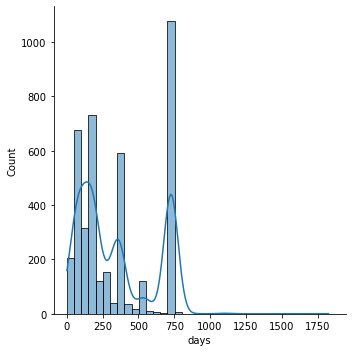

In [660]:
length_data = pd.read_csv("cleaned_length.csv")["days"].dropna()

print(f"Mean: {length_data.mean():.0f} days")
print(f"Median: {length_data.median():.0f} days")
print(f"Mode: {length_data.mode()[0]:.0f} days")

sns.displot(length_data, kde=True, binwidth=50)

Next the average budget.

Again, some very heavy outliers which strongly affect the mean but not the median or mode.

In [671]:
budget_data = pd.read_csv("cleaned_budget.csv").budget.dropna()

print(f"Mean: \t\t£{budget_data.mean():.0f}")
print(f"Median: \t£{budget_data.median():.0f}")
print(f"Mode: \t\t£{budget_data.mode()[0]:.0f}")


Mean: 		£1713803
Median: 	£252000
Mode: 		£100000


And a histogram with kde curve:

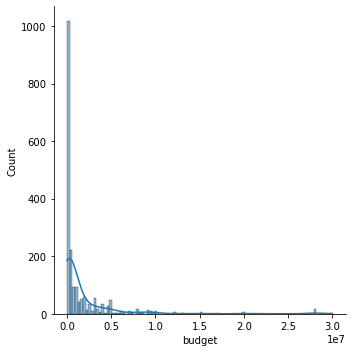

In [672]:
graph = sns.displot(budget_data, bins=100, kde=True)

To export to JSON we need to join the data together and rename the columns before saving to a file.

In [683]:
length_data = pd.read_csv("cleaned_length.csv", index_col=0)
budget_data = pd.read_csv("cleaned_budget.csv", index_col=0)
output_data = length_data.join(budget_data)
output_data.rename(columns={"days": "Expected Contract Length", "budget": "Budget Range"}, inplace=True)
output_data.head()

,Expected Contract Length,budget_text,contains_day,Budget Range
5,56.0,c£100kforpeople£7kfortech,False,100000.0
9,730.0,TheCall-Offcontractwillhaveamaximumvalueofupto...,False,28000000.0
19,270.0,NaN,NaN,NaN
20,268.0,NaN,NaN,NaN
28,270.0,NaN,NaN,NaN


Lets remove those extra columns that aren't needed.

In [684]:
output_data = output_data[["Expected Contract Length", "Budget Range"]]
output_data.head()

,Expected Contract Length,Budget Range
5,56.0,100000.0
9,730.0,28000000.0
19,270.0,NaN
20,268.0,NaN
28,270.0,NaN


And finally export to JSON.

In [688]:
output_data.to_json("output.json", orient="index", indent=4)

## Bonus Visualisations
I'm interested in whether longer contracts mean higher budget or not.

I start by visualising using a two way histogram.

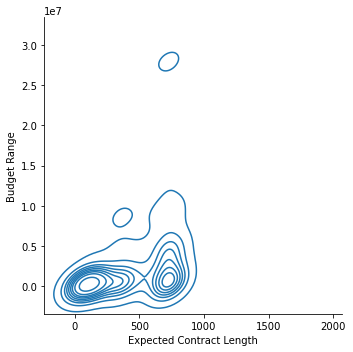

In [689]:
sns.displot(output_data, x="Expected Contract Length", y="Budget Range", kind="kde")

The axes here are not very useful - I would like to convert contract length from a unit of days into years and trim the data to only show contract length up to 3 years (1095 days) and budget up to £1.5 million.

I hope that this will give us a closer look at the trends for the majority of the data.

In [691]:
output_data["Expected Contract Length / years"] = output_data["Expected Contract Length"] / 365
filtered_data = output_data[output_data["Expected Contract Length / years"] <= 3]
filtered_data = filtered_data[filtered_data["Budget Range"] <= 1500000]

Now lets look at that histogram again.

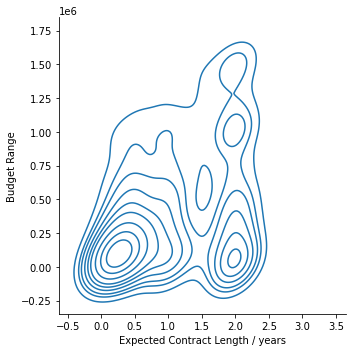

In [702]:
sns.displot(filtered_data, x="Expected Contract Length / years", y="Budget Range", kind="kde")

I don't like that this shows negative time and budget values.

If I use a regular histogram rather than KDE curves this will prevent showing these negative values.

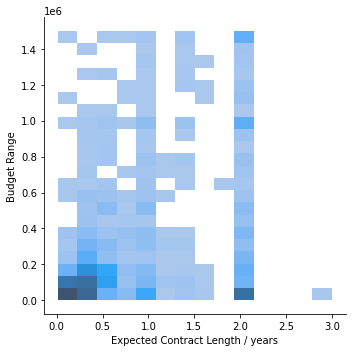

In [703]:
sns.displot(filtered_data, x="Expected Contract Length / years", y="Budget Range")

Overall this seems to show that most contracts are either two years or less than 6 months with a budget of under £200,000.